## Imports & Setup

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, RandomHorizontalFlip
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from helpers import *
from architecture.Transformer import *

from torchsampler import ImbalancedDatasetSampler

In [2]:
torch.manual_seed(109)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Prepare Dataset

In [4]:
def create_subsets(root, transformation):
    dataset = ImageFolder(root, transformation)
    train, test, val = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])
    return train, test, val

In [5]:
def produce_loaders(train, test, val):
    train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
    test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
    valid_loader = torch.utils.data.DataLoader(val, batch_size = batch_size, shuffle = False)
    return train_loader, test_loader, valid_loader

In [7]:
size = 32
batch_size = 128
transformation = Compose([RandomHorizontalFlip(), Resize((size, size)), ToTensor()])

In [8]:
root = 'expanded_dataset/cropped_aug'
train_data, test_data, val_data = create_subsets(root, transformation)
train_loader, test_loader, val_loader = produce_loaders(train_data, test_data, val_data)

[1052, 7937, 1838, 7803, 5960, 501, 8102, 1934, 4330]


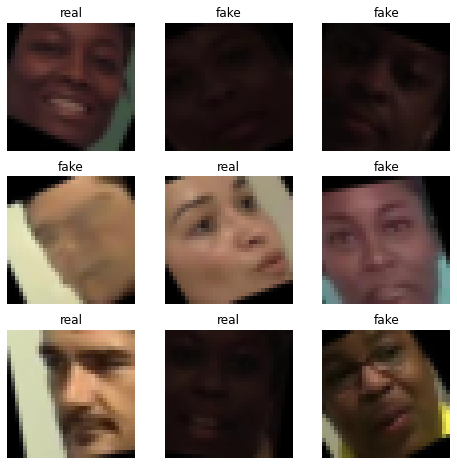

In [9]:
visualize_data(train_data)

[927, 33, 81, 161, 65, 356, 1025, 456, 265]


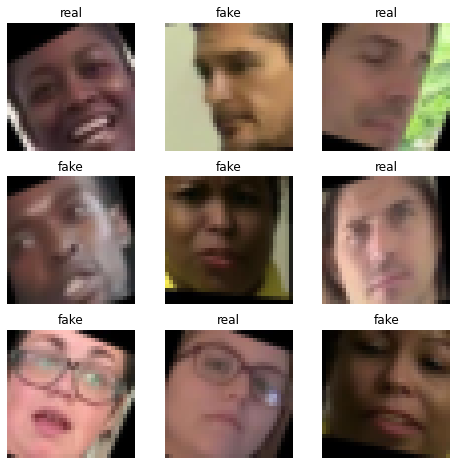

In [10]:
visualize_data(test_data)

## Initialize Model

In [11]:
def create_adam_optimizer(model, lr = 0.1, betas=(0.9, 0.999), amsgrad=False):
    return optim.Adam(model.parameters(), lr = lr, amsgrad=amsgrad, betas=betas)

In [12]:
from math import floor
# number of convolutional 'embedding' layers and their sizes
hidden = [3, 256, 64, 32]

# kernel size of convolution layers
kernel_size = 3

# window size of avgpooling layer
window = 2

# calculate final size of image
channels = hidden[-1]
changed_img = floor( (size-(kernel_size-1)*(len(hidden)-1)) / window )

# calculate dimension of flattened image
flattened = channels*changed_img*changed_img
blocks = [flattened, 512, 64]

In [13]:
model = Transformer(hidden, kernel_size, window, blocks).to(device)
print(model)

Transformer(
  (conv_combined): Sequential(
    (0): ConvEmbed(
      (conv): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (1): ConvEmbed(
      (conv): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (2): ConvEmbed(
      (conv): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
  )
  (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (blocks_combined): Sequential(
    (0): TransformerBlock(
      (attention): AttentionLayer(
        (query): Linear(in_features=5408, out_features=5408, bias=True)
       

## Training Model

In [14]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [15]:
optimizer = create_adam_optimizer(model, lr = 0.001)

In [16]:
tl, ta, vl, va = train(device, model,
                       train_loader, val_loader, 
                       optimizer, epochs = 20)
train_losses+=tl
train_accuracies+=ta
val_losses+=vl
val_accuracies+=va

Epoch 1/20, Batch number: 0, Cumulated accuracy: 0.5703125
Epoch 1/20, Batch number: 5, Cumulated accuracy: 0.5013020833333334
Epoch 1/20, Batch number: 10, Cumulated accuracy: 0.5021306818181818
Epoch 1/20, Batch number: 15, Cumulated accuracy: 0.51904296875
Epoch 1/20, Batch number: 20, Cumulated accuracy: 0.5230654761904762
Epoch 1/20, Batch number: 25, Cumulated accuracy: 0.5306490384615384
Epoch 1/20, Batch number: 30, Cumulated accuracy: 0.538054435483871
Epoch 1/20, Batch number: 35, Cumulated accuracy: 0.5440538194444444
Epoch 1/20, Batch number: 40, Cumulated accuracy: 0.5434451219512195
Epoch 1/20, Batch number: 45, Cumulated accuracy: 0.548233695652174
Epoch 1/20, Batch number: 50, Cumulated accuracy: 0.5502450980392157
Epoch 1/20, Batch number: 55, Cumulated accuracy: 0.5517578125
Epoch 1/20, Batch number: 60, Cumulated accuracy: 0.5531506147540983
--- Epoch 1/20: Train loss: 0.7115, Train accuracy: 0.5541
--- Epoch 1/20: Val loss: 0.6316, Val accuracy: 0.6908
Epoch 2/20, B

Epoch 9/20, Batch number: 25, Cumulated accuracy: 0.6430288461538461
Epoch 9/20, Batch number: 30, Cumulated accuracy: 0.6489415322580645
Epoch 9/20, Batch number: 35, Cumulated accuracy: 0.6486545138888888
Epoch 9/20, Batch number: 40, Cumulated accuracy: 0.6545350609756098
Epoch 9/20, Batch number: 45, Cumulated accuracy: 0.65625
Epoch 9/20, Batch number: 50, Cumulated accuracy: 0.6567095588235294
Epoch 9/20, Batch number: 55, Cumulated accuracy: 0.65625
Epoch 9/20, Batch number: 60, Cumulated accuracy: 0.6570184426229508
--- Epoch 9/20: Train loss: 0.6206, Train accuracy: 0.6572
--- Epoch 9/20: Val loss: 0.4944, Val accuracy: 0.8242
Epoch 10/20, Batch number: 0, Cumulated accuracy: 0.7734375
Epoch 10/20, Batch number: 5, Cumulated accuracy: 0.6927083333333334
Epoch 10/20, Batch number: 10, Cumulated accuracy: 0.6789772727272727
Epoch 10/20, Batch number: 15, Cumulated accuracy: 0.6708984375
Epoch 10/20, Batch number: 20, Cumulated accuracy: 0.6741071428571429
Epoch 10/20, Batch numb

Epoch 17/20, Batch number: 45, Cumulated accuracy: 0.6980298913043478
Epoch 17/20, Batch number: 50, Cumulated accuracy: 0.6996017156862745
Epoch 17/20, Batch number: 55, Cumulated accuracy: 0.6986607142857143
Epoch 17/20, Batch number: 60, Cumulated accuracy: 0.7005635245901639
--- Epoch 17/20: Train loss: 0.5772, Train accuracy: 0.7006
--- Epoch 17/20: Val loss: 0.4441, Val accuracy: 0.8135
Epoch 18/20, Batch number: 0, Cumulated accuracy: 0.6875
Epoch 18/20, Batch number: 5, Cumulated accuracy: 0.71875
Epoch 18/20, Batch number: 10, Cumulated accuracy: 0.7230113636363636
Epoch 18/20, Batch number: 15, Cumulated accuracy: 0.724609375
Epoch 18/20, Batch number: 20, Cumulated accuracy: 0.7131696428571429
Epoch 18/20, Batch number: 25, Cumulated accuracy: 0.7115384615384616
Epoch 18/20, Batch number: 30, Cumulated accuracy: 0.7111895161290323
Epoch 18/20, Batch number: 35, Cumulated accuracy: 0.7109375
Epoch 18/20, Batch number: 40, Cumulated accuracy: 0.7122713414634146
Epoch 18/20, Ba

## Testing Model & Performance Curves

In [26]:
true_labels, model_preds, test_loss, test_accuracy = test(device, model, test_loader, get_predictions=True)

Test loss: 0.4552, Test accuracy: 0.8077


Precision: 0.8150406504065041
Recall: 0.787819253438114
F1 score: 0.8011988011988013


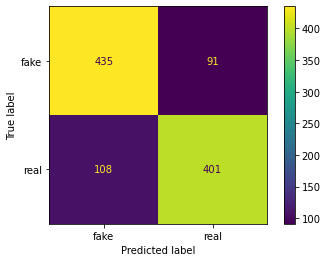

In [27]:
show_metrics(true_labels, model_preds)

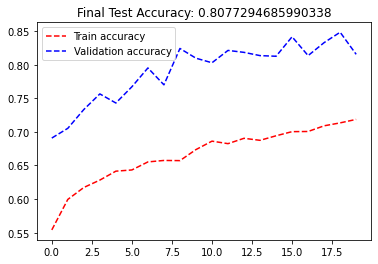

In [28]:
plt.plot(train_accuracies, "r--", label='Train accuracy')
plt.plot(val_accuracies, "b--", label='Validation accuracy')
plt.title("Final Test Accuracy: {}".format(test_accuracy))
plt.legend(loc='upper left')
plt.show()

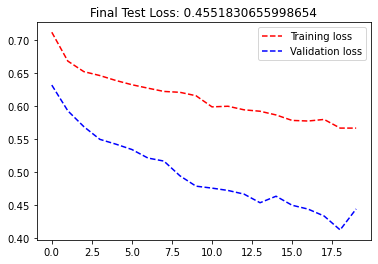

In [29]:
plt.plot(train_losses, "r--", label='Training loss')
plt.plot(val_losses, "b--", label='Validation loss')
plt.title("Final Test Loss: {}".format(test_loss))
plt.legend(loc='upper right')
plt.show()

## Viewing Model Predictions

In [30]:
test_loader2 = produce_loader(test_data, 1)

In [31]:
correct_list, wrong_list, true_labels2, model_preds2 = get_pictures_test(device, model, test_loader2)

Precision: 0.8224489795918367
Recall: 0.7917485265225933
F1 score: 0.8068068068068068


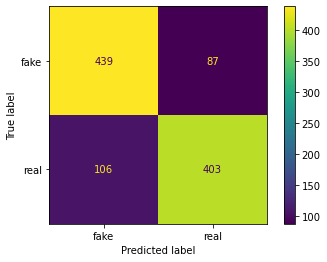

In [32]:
show_metrics(true_labels2, model_preds2)

[262, 800, 528, 705, 621, 113, 282, 645, 590, 66, 559, 683, 63, 656, 714, 89, 666, 319, 536, 408, 185, 206, 402, 386, 657]


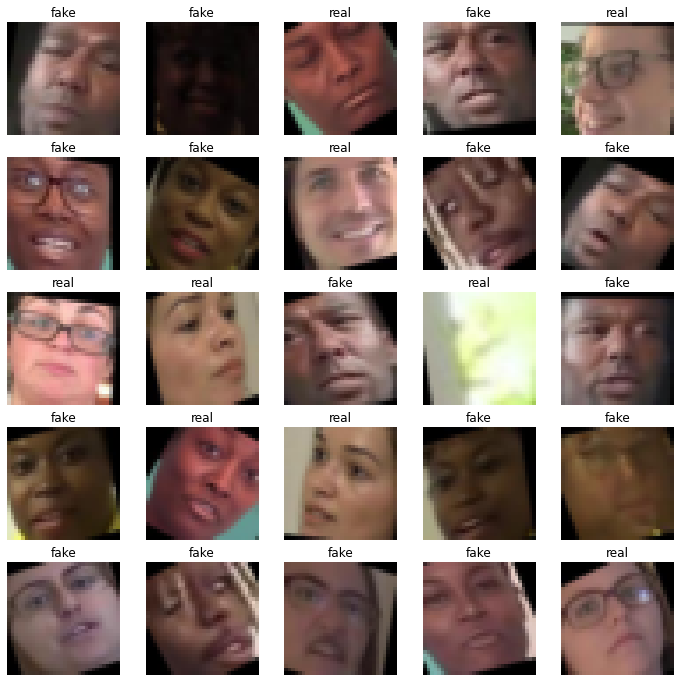

In [33]:
visualize_data(correct_list, (12,12), 5)

[59, 160, 191, 46, 129, 65, 178, 91, 20, 149, 91, 64, 145, 182, 111, 93, 186, 66, 52, 5, 5, 154, 140, 90, 85]


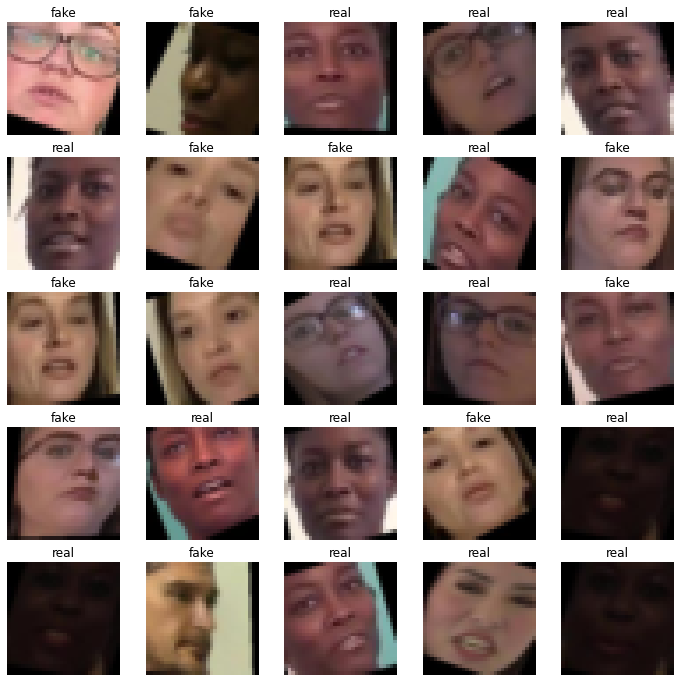

In [34]:
visualize_data(wrong_list, (12,12), 5)

## Saving Model

In [25]:
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()}, 
            './transformer_17epochs')